## An OMOP Cohort: Patients Exposed to Amiodarone Hydrochloride > 30 Days

### Part IV: A Longitudinal Time Series Preparation & Exploration

An examination of de-identified longitudinal visit and procedure data (derived to OMOP from Medicare DeSYNPuf data, 2008-2010, by OHDSI) and associated ICD9CM diagnosis codes to analyze the incidence and prevalence of AEs associated with amiodarone toxicity to the lung, thyroid and liver.

Kyle P. Rasku MS BSN RN

In [1]:
%matplotlib inline
import random
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

In [2]:
condition_visits_ds = pd.read_csv("conditions_visits_procedures.csv", parse_dates=["treatment_start", "vstart", 
                                                                                   "condition_start_date", "condition_end_date"])

In [3]:
sentinel_visits_ds = condition_visits_ds[["patient_id", "treatment_start", "treatment_period", "visit_id", "vstart", 
                                          "sentinel_condition_code", "sentinel_condition_name", "sentinel_snomed_name", 
                                          "sentinel_condition_type", "condition_start_date", "condition_end_date", 
                                          "condition_interval_days", "treatment_condition_interval_days"]].copy().reset_index()

Calculate treatment end-dates.

In [4]:
from datetime import datetime
censorship_date = datetime.strptime('01/01/2011', '%m/%d/%Y')

condition_visits_ds.loc[condition_visits_ds["treatment_condition_interval_days"].isnull(), "censored"] = 1
sentinel_visits_ds.loc[sentinel_visits_ds["treatment_condition_interval_days"].isnull(), "censored"] = 1
condition_visits_ds.loc[condition_visits_ds["censored"].isnull(), "censored"] = 0
sentinel_visits_ds.loc[sentinel_visits_ds["censored"].isnull(), "censored"] = 0

# df['C'].fillna(df.A * df.B)
condition_visits_ds["treatment_condition_interval_days"] = condition_visits_ds["treatment_condition_interval_days"].fillna(censorship_date - condition_visits_ds["treatment_start"])
sentinel_visits_ds["treatment_condition_interval_days"] = sentinel_visits_ds["treatment_condition_interval_days"].fillna(censorship_date - sentinel_visits_ds["treatment_start"])

In [5]:
condition_visits_ds["treatment_condition_interval_months"] = (condition_visits_ds['vstart'] - condition_visits_ds['treatment_start'])/np.timedelta64(1, 'M')

sentinel_visits_ds["treatment_condition_interval_months"] = (sentinel_visits_ds['vstart'] - sentinel_visits_ds['treatment_start'])/np.timedelta64(1, 'M')
sentinel_visits_ds = sentinel_visits_ds[sentinel_visits_ds["condition_start_date"].notnull()]

In [6]:
visit_codes = sentinel_visits_ds.groupby("visit_id")["sentinel_condition_code"].count().reset_index()
visit_codes.columns = ["visit_id", "condition_code_count"]

In [7]:
sentinel_visits_ds["censored"] = sentinel_visits_ds["censored"].astype("int64")
sentinel_visits_ds["condition_interval_days"] = sentinel_visits_ds["condition_interval_days"].astype("int64")

In [8]:
sentinel_visits = sentinel_visits_ds[["visit_id", "vstart", "treatment_period", "condition_interval_days", 
                                      "treatment_condition_interval_days", "treatment_condition_interval_months"]].copy()

sentinel_visits = pd.merge(sentinel_visits, visit_codes, on="visit_id", how="left").sort_values(by="vstart").set_index("vstart")

## Sentinel Visits

Visits where patients had a lung, liver or thyroid diagnosis following amiodarone exposure.

array([<AxesSubplot:xlabel='vstart'>, <AxesSubplot:xlabel='vstart'>,
       <AxesSubplot:xlabel='vstart'>, <AxesSubplot:xlabel='vstart'>,
       <AxesSubplot:xlabel='vstart'>], dtype=object)

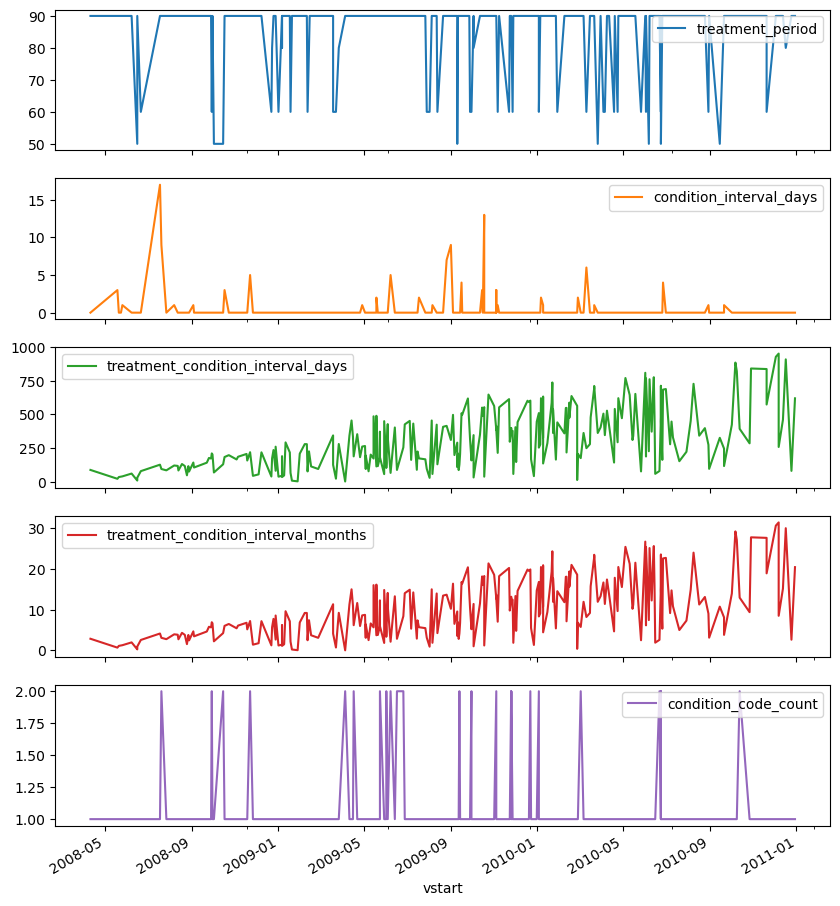

In [9]:
sentinel_visits = sentinel_visits.drop(["visit_id"], axis=1, errors="ignore")
sentinel_visits.plot(subplots=True, figsize=(10,12))

## The Average Interval Between Amiodarone Treatment and a Sentinel Visit

In weeks, then months.

<AxesSubplot:xlabel='vstart'>

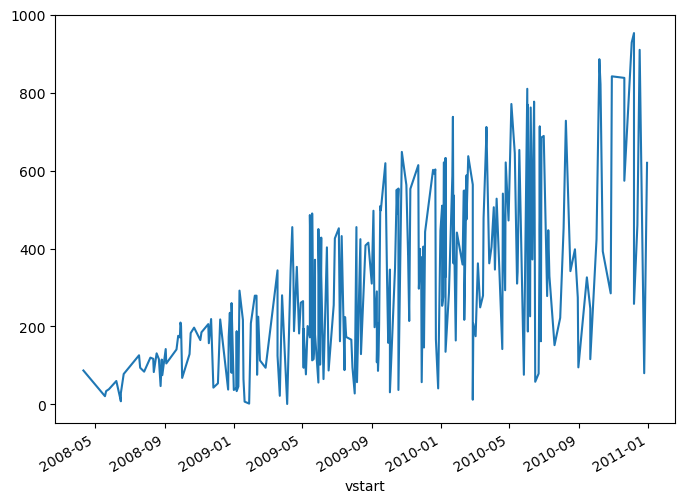

In [10]:
sentinel_visits["treatment_condition_interval_days"].plot(figsize=(8, 6))

<AxesSubplot:xlabel='vstart'>

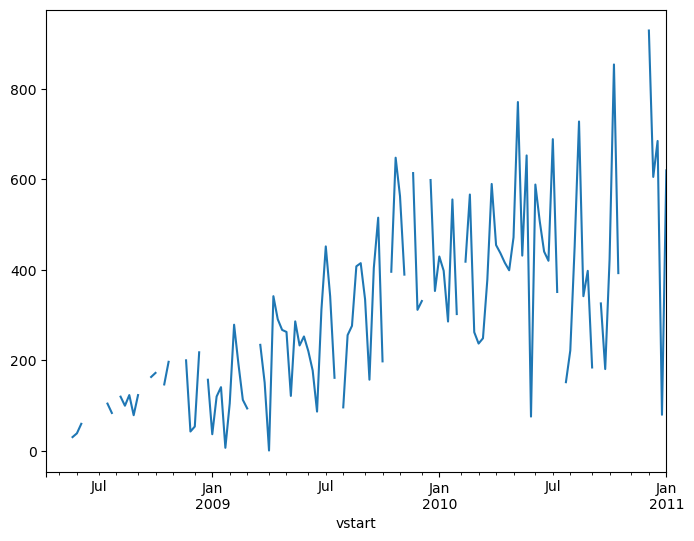

In [11]:
df = sentinel_visits["treatment_condition_interval_days"]
df_week = df.resample("W").mean()
df_week.plot(figsize=(8, 6))

<AxesSubplot:xlabel='vstart'>

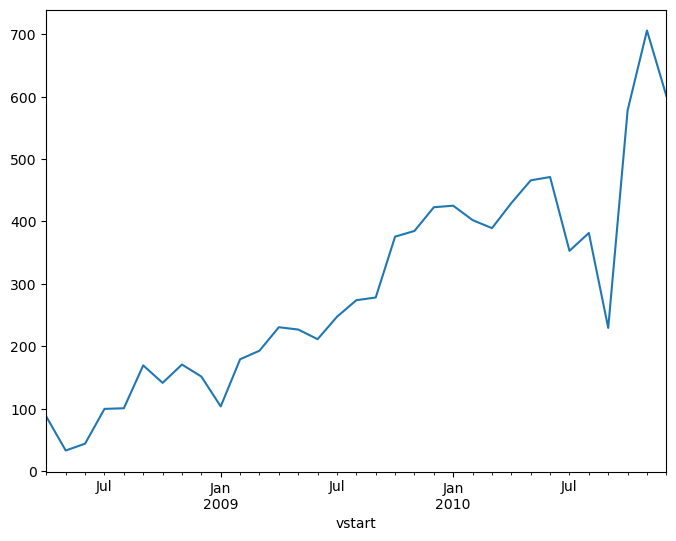

In [12]:
df_month = df.resample("M").mean()
df_month.plot(figsize=(8, 6))

While the trend is apparent at the month level, seasonality can be better seen at the week level.

In [13]:
sentinel_visits_ts = sentinel_visits.reset_index()
sentinel_visits_ts.to_csv("sentinel_visits_ts.csv")

In [14]:
visits_ds = pd.read_csv("amiodarone_exposed_visits.csv", parse_dates=["treatment_start", "vstart", "vend"])
procedures_ds = pd.read_csv("amiodarone_exposed_procedures.csv", parse_dates=["drug_treatment_start", "vstart", "vend"])

In [15]:
visit_diagnoses = visits_ds[["visit_id", "diagnosis_name", "snomed_code", "ICD9CODE"]].copy()
visit_diagnoses.columns = ["visit_id", "diagnosis", "snomed_code", "icd9_code"]
visit_diagnoses.head()

,visit_id,diagnosis,snomed_code,icd9_code
0,5351372,Vomiting,422400008,78703
1,5351372,Epidemic vertigo,186738001,38612
2,5351385,Atrial fibrillation,49436004,42731
3,5351385,Atrial fibrillation,49436004,42731
4,5351385,Paroxysmal supraventricular tachycardia,67198005,4270


In [16]:
vg = visit_diagnoses.groupby(['visit_id'], as_index = False).agg({'diagnosis' : 'count'})
vg.columns = ["visit_id", "diagnosis_count"]

In [17]:
visits_ds = visits_ds[["patient_id", "treatment_start", "treatment_period", "visit_id", "vstart", "vprovider","care_site"]].copy()
visits_ds = visits_ds.drop_duplicates()
visits_ds = pd.merge(visits_ds, vg, on="visit_id")

In [18]:
procedures_ds.loc[procedures_ds["procedure_code"]=="None", "procedure_code"] = np.nan

pg = procedures_ds.groupby(['visit_id'], as_index = False).agg({'procedure_code': 'count'})
pg.columns = ["visit_id", "procedure_count"]

procedures_ds = procedures_ds[["patient_id", "drug_treatment_start", "drug_treatment_period", "visit_id", "vstart", "vprovider", "care_site"]].copy()
procedures_ds = procedures_ds.drop_duplicates()
procedures_ds = pd.merge(procedures_ds, pg, on="visit_id")

In [19]:
visits_procedures_ds = pd.merge(visits_ds, procedures_ds, on="visit_id", how="left")
visits_procedures_ds = visits_procedures_ds[["patient_id_x", "treatment_start", "treatment_period", "visit_id", "vstart_x", "diagnosis_count", "procedure_count"]].copy().reset_index()
visits_procedures_ds.drop(["index"], axis=1, inplace=True)
visits_procedures_ds.columns = ["patient_id", "treatment_start", "treatment_period", "visit_id", "vstart", "diagnosis_count", "procedure_count"]


The visits_procedures dataset contains NO sentinel visits or diagnoses, so all treatment_condition intervals should be set to the censorship value for these visits.

In [20]:
visits_procedures_ds["treatment_condition_interval_days"] = censorship_date - visits_procedures_ds["treatment_start"]
visits_procedures_ds["censored"] = 1
visits_procedures_ds["treatment_condition_interval_months"] = (censorship_date - condition_visits_ds['treatment_start'])/np.timedelta64(1, 'M')

# Fill null values for diagnoses and procedure counts to 0
visits_procedures_ds.loc[visits_procedures_ds["diagnosis_count"].isnull(), "diagnosis_count"] = 0
visits_procedures_ds.loc[visits_procedures_ds["procedure_count"].isnull(), "procedure_count"] = 0

In [21]:
# Convert timedelta days to float, and convert procedure_count to int64

visits_procedures_ds['treatment_condition_interval_days'] = visits_procedures_ds['treatment_condition_interval_days'].dt.days
visits_procedures_ds['procedure_count'] = visits_procedures_ds['procedure_count'].astype("int64")

sentinel_visits_ds["censored"] = sentinel_visits_ds["censored"].astype("int64")
sentinel_visits_ds = sentinel_visits_ds.reset_index()


In [22]:
sentinel_visits_ds.drop(["level_0", "index"], axis=1, inplace=True, errors="ignore")
# sentinel_visits_ds.info()

In [25]:
for i in range(0, len(sentinel_visits_ds)):
    if sentinel_visits_ds.at[i, "censored"] == 0:
        # update visits_procedures_ds with these values
        visits_procedures_ds.loc[visits_procedures_ds["visit_id"] == sentinel_visits_ds.at[i, "visit_id"], "censored"] = 0
        visits_procedures_ds.loc[visits_procedures_ds["visit_id"] == sentinel_visits_ds.at[i, "visit_id"], "treatment_condition_interval_days"] = sentinel_visits_ds.at[i, "treatment_condition_interval_days"]
        visits_procedures_ds.loc[visits_procedures_ds["visit_id"] == sentinel_visits_ds.at[i, "visit_id"], "treatment_condition_interval_months"] = sentinel_visits_ds.at[i, "treatment_condition_interval_months"]
        visits_procedures_ds.loc[visits_procedures_ds["visit_id"] == sentinel_visits_ds.at[i, "visit_id"], "condition_interval_days"] = sentinel_visits_ds.at[i, "condition_interval_days"]
        visits_procedures_ds.loc[visits_procedures_ds["visit_id"] == sentinel_visits_ds.at[i, "visit_id"], "sentinel_condition_type"] = sentinel_visits_ds.at[i, "sentinel_condition_type"]

In [26]:
visits_procedures_ds.loc[visits_procedures_ds["condition_interval_days"].isnull(), "condition_interval_days"] = 0
visits_procedures_ds.loc[visits_procedures_ds["sentinel_condition_type"].isnull(), "sentinel_condition_type"] = "NONE"

In [27]:
visits_procedures_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5600 entries, 0 to 5599
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   patient_id                           5600 non-null   int64         
 1   treatment_start                      5600 non-null   datetime64[ns]
 2   treatment_period                     5600 non-null   int64         
 3   visit_id                             5600 non-null   int64         
 4   vstart                               5600 non-null   datetime64[ns]
 5   diagnosis_count                      5600 non-null   int64         
 6   procedure_count                      5600 non-null   int64         
 7   treatment_condition_interval_days    5600 non-null   int64         
 8   censored                             5600 non-null   int64         
 9   treatment_condition_interval_months  5600 non-null   float64       
 10  condition_in

## All Cohort Visits

Time series plots, all patient visits for amiodarone exposed cohort.

In [34]:
visits_ts = visits_procedures_ds[["vstart", "treatment_start", "treatment_period", "diagnosis_count", "procedure_count",
                                  "treatment_condition_interval_days", "treatment_condition_interval_months",
                                  "condition_interval_days", "sentinel_condition_type"]].set_index("vstart")

array([<AxesSubplot:xlabel='vstart'>, <AxesSubplot:xlabel='vstart'>,
       <AxesSubplot:xlabel='vstart'>, <AxesSubplot:xlabel='vstart'>,
       <AxesSubplot:xlabel='vstart'>, <AxesSubplot:xlabel='vstart'>,
       <AxesSubplot:xlabel='vstart'>], dtype=object)

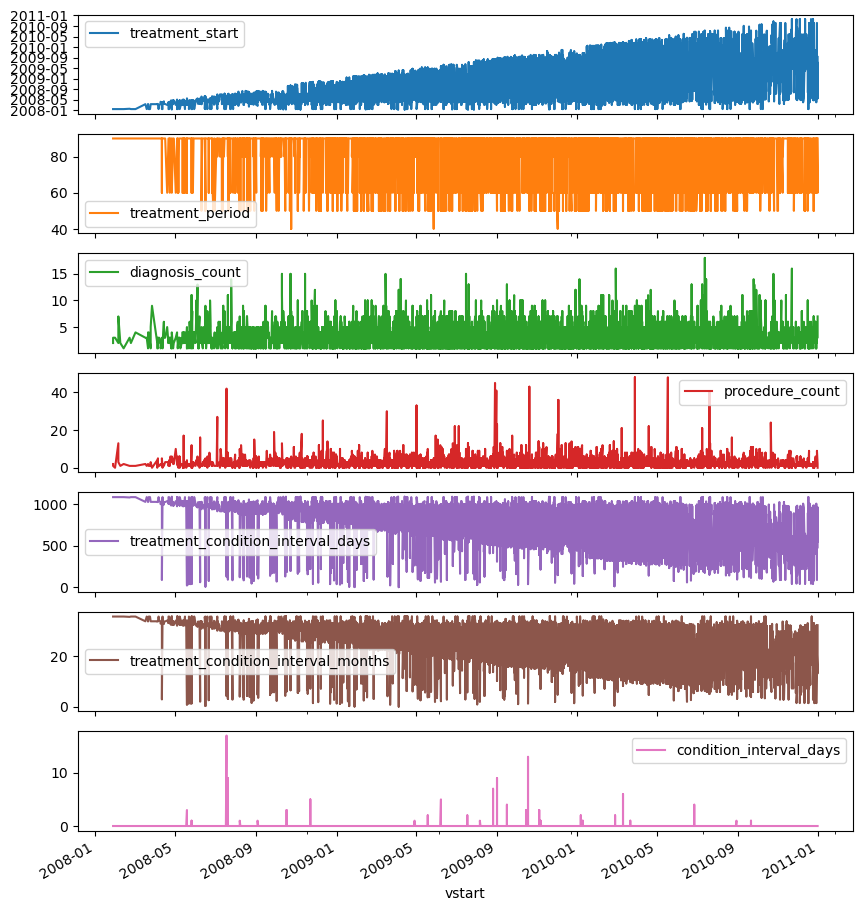

In [35]:
visits_ts.plot(subplots=True, figsize=(10,12))

## 2008 Cohort Visits

array([<AxesSubplot:xlabel='vstart'>, <AxesSubplot:xlabel='vstart'>,
       <AxesSubplot:xlabel='vstart'>, <AxesSubplot:xlabel='vstart'>,
       <AxesSubplot:xlabel='vstart'>, <AxesSubplot:xlabel='vstart'>,
       <AxesSubplot:xlabel='vstart'>], dtype=object)

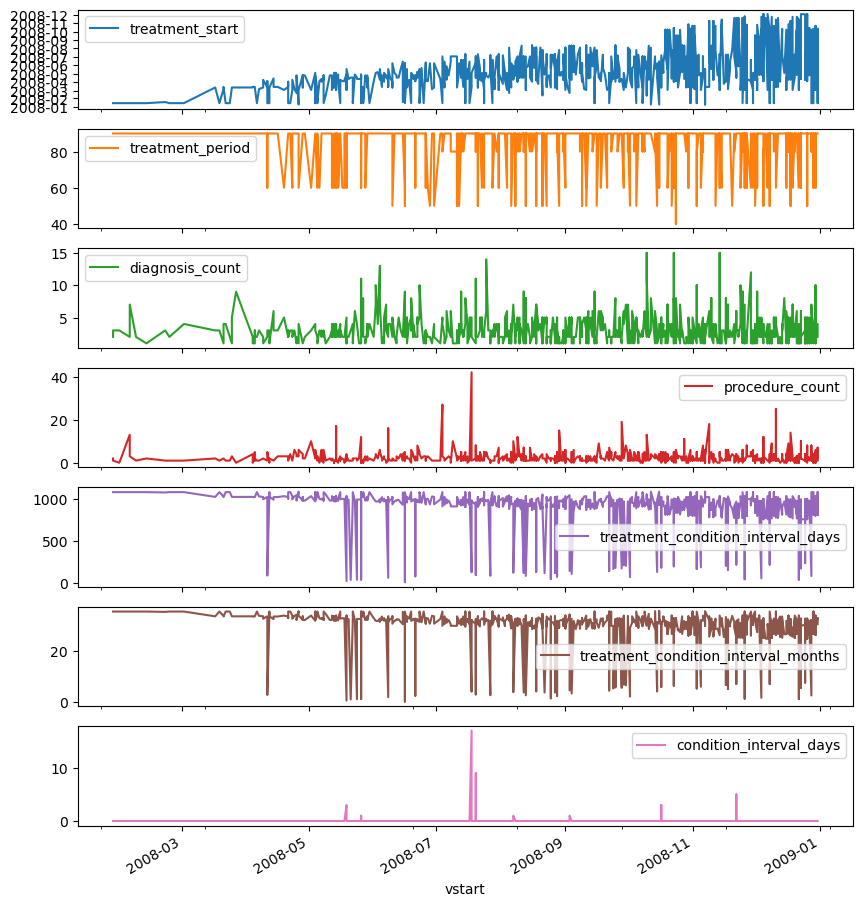

In [36]:
visits_ts.loc['2008'].plot(subplots=True, figsize=(10,12))

## 2009 Cohort Visits

array([<AxesSubplot:xlabel='vstart'>, <AxesSubplot:xlabel='vstart'>,
       <AxesSubplot:xlabel='vstart'>, <AxesSubplot:xlabel='vstart'>,
       <AxesSubplot:xlabel='vstart'>, <AxesSubplot:xlabel='vstart'>,
       <AxesSubplot:xlabel='vstart'>], dtype=object)

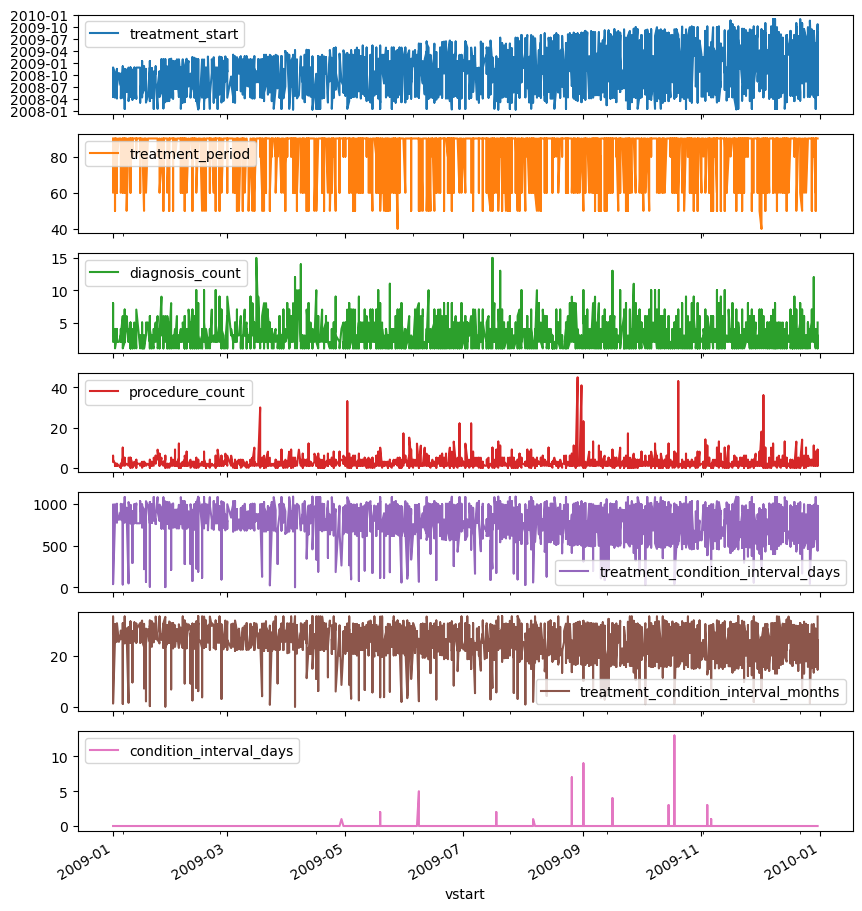

In [37]:
visits_ts.loc['2009'].plot(subplots=True, figsize=(10,12))

## 2010 Cohort Visits

array([<AxesSubplot:xlabel='vstart'>, <AxesSubplot:xlabel='vstart'>,
       <AxesSubplot:xlabel='vstart'>, <AxesSubplot:xlabel='vstart'>,
       <AxesSubplot:xlabel='vstart'>, <AxesSubplot:xlabel='vstart'>,
       <AxesSubplot:xlabel='vstart'>], dtype=object)

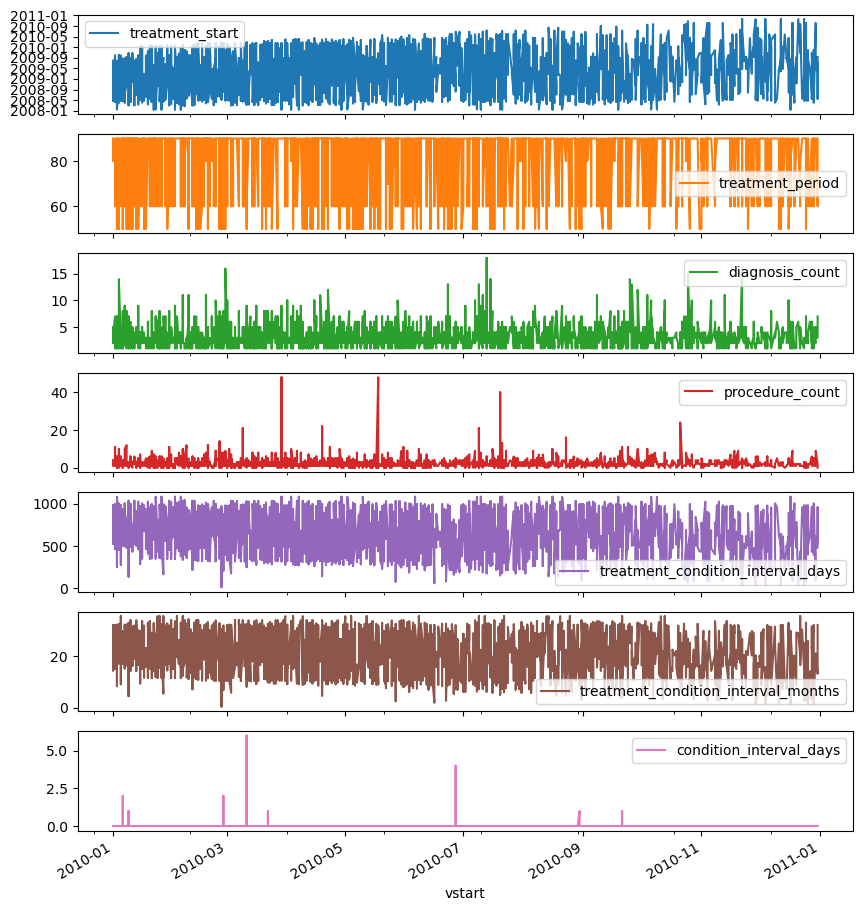

In [38]:
visits_ts.loc['2010'].plot(subplots=True, figsize=(10,12))

In [39]:
treatments_ts = visits_procedures_ds[["vstart", "treatment_start", "treatment_period", "diagnosis_count", "procedure_count",
                                  "treatment_condition_interval_days", "treatment_condition_interval_months",
                                  "condition_interval_days", "sentinel_condition_type"]].set_index("treatment_start")

## Visits by Treatment Start

for amiodarone exposed cohort

array([<AxesSubplot:xlabel='treatment_start'>,
       <AxesSubplot:xlabel='treatment_start'>,
       <AxesSubplot:xlabel='treatment_start'>,
       <AxesSubplot:xlabel='treatment_start'>,
       <AxesSubplot:xlabel='treatment_start'>,
       <AxesSubplot:xlabel='treatment_start'>,
       <AxesSubplot:xlabel='treatment_start'>], dtype=object)

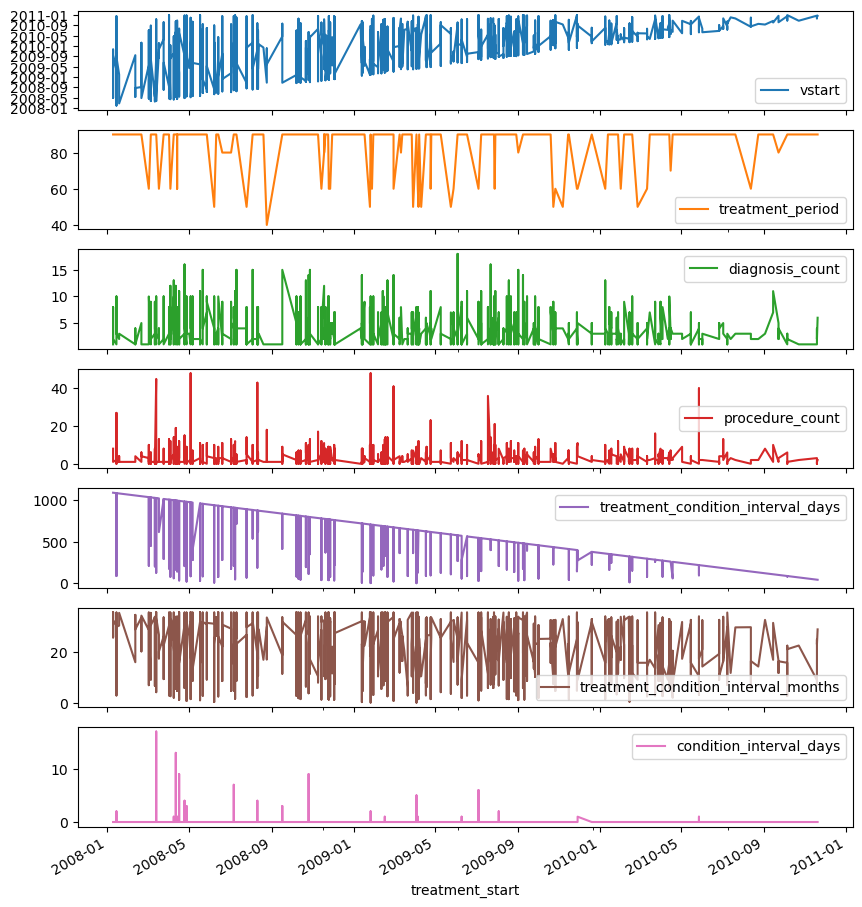

In [40]:
treatments_ts.plot(subplots=True, figsize=(10,12))

## 2008 Treatment Start Visits

array([<AxesSubplot:xlabel='treatment_start'>,
       <AxesSubplot:xlabel='treatment_start'>,
       <AxesSubplot:xlabel='treatment_start'>,
       <AxesSubplot:xlabel='treatment_start'>,
       <AxesSubplot:xlabel='treatment_start'>,
       <AxesSubplot:xlabel='treatment_start'>,
       <AxesSubplot:xlabel='treatment_start'>], dtype=object)

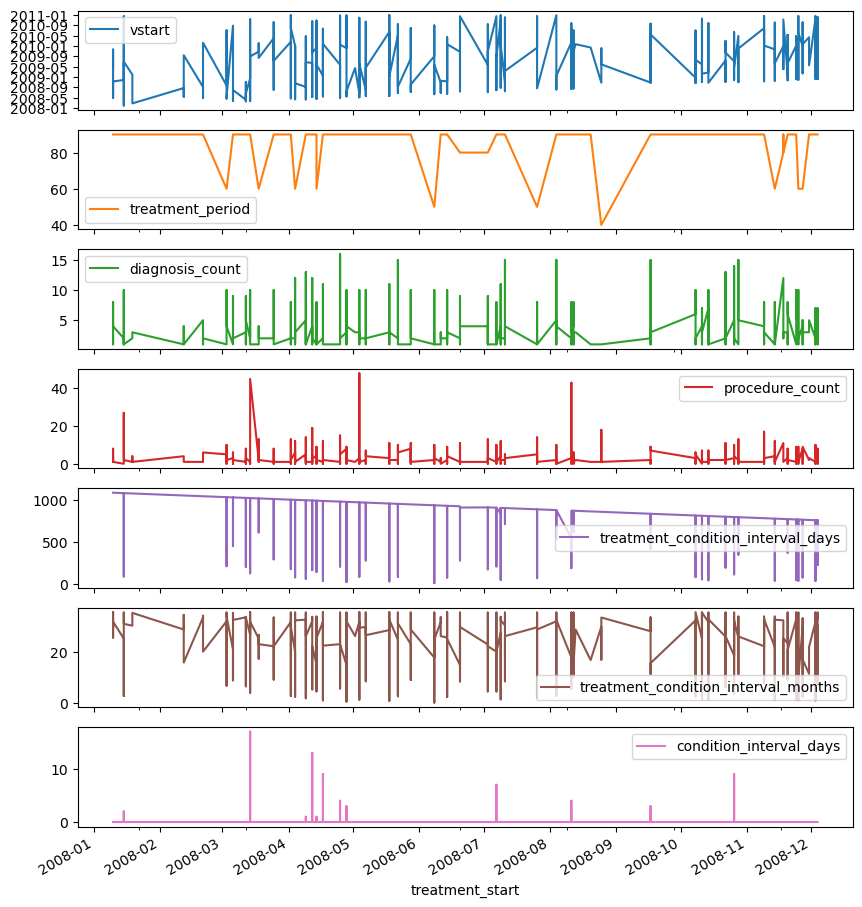

In [41]:
treatments_ts.loc['2008'].plot(subplots=True, figsize=(10,12))

## 2009 Treatment Start Visits

array([<AxesSubplot:xlabel='treatment_start'>,
       <AxesSubplot:xlabel='treatment_start'>,
       <AxesSubplot:xlabel='treatment_start'>,
       <AxesSubplot:xlabel='treatment_start'>,
       <AxesSubplot:xlabel='treatment_start'>,
       <AxesSubplot:xlabel='treatment_start'>,
       <AxesSubplot:xlabel='treatment_start'>], dtype=object)

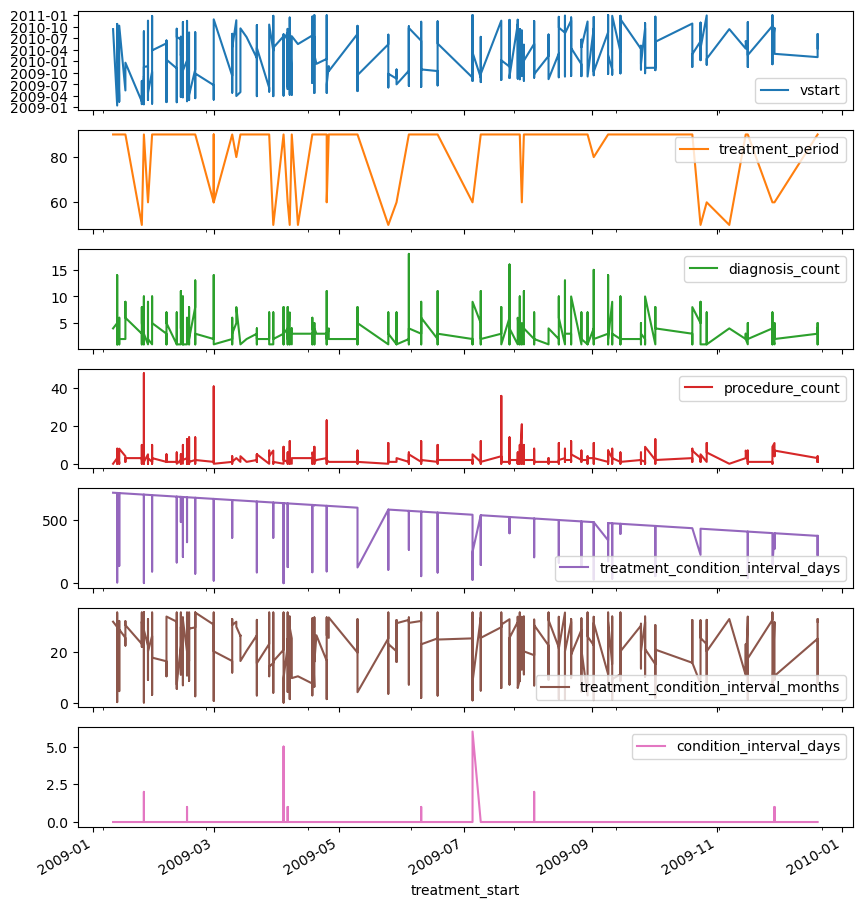

In [42]:
treatments_ts.loc['2009'].plot(subplots=True, figsize=(10,12))

## 2010 Treatment Start Visits

array([<AxesSubplot:xlabel='treatment_start'>,
       <AxesSubplot:xlabel='treatment_start'>,
       <AxesSubplot:xlabel='treatment_start'>,
       <AxesSubplot:xlabel='treatment_start'>,
       <AxesSubplot:xlabel='treatment_start'>,
       <AxesSubplot:xlabel='treatment_start'>,
       <AxesSubplot:xlabel='treatment_start'>], dtype=object)

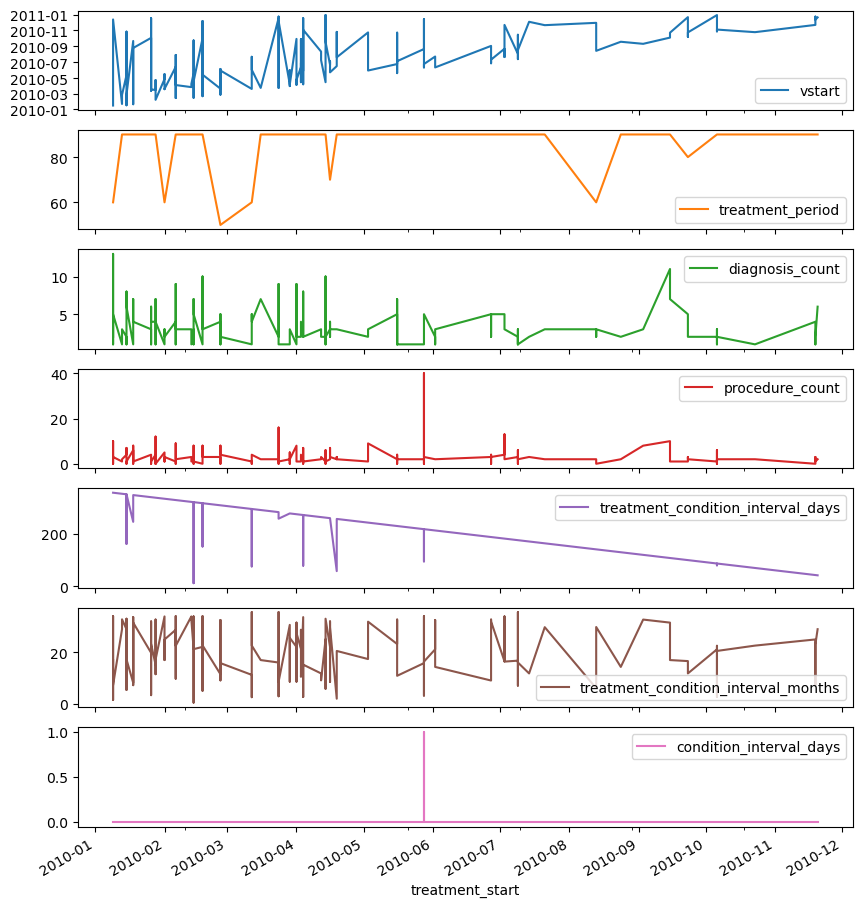

In [43]:
treatments_ts.loc['2010'].plot(subplots=True, figsize=(10,12))

In [44]:
visits_procedures_ds.to_csv("all_visits_ts.csv")